#**Workshop 9 - Introduction to Deep Neural Networks**

The aim of this week's workshop is to explore various deep neural network tasks using the fashion MNIST dataset from within keras. Fashion MNIST considers 60,000 images of 10 different fashion categories (for training) and 10,000 images for testing. You can see few examples in the next image. We will also use Keras (within tensorflow v2) to build a small fully connected network that will be used to make predictions about which fashion category each image should be classified into.

#**Part 1 [As a class, 15 mins] : Load and inspect data**

Go through the discussion and part 1 slides in provided powerpoint as the students run through the code in the provided cells, pointing out how to interpret the input data and the dataset splitting code.

Note: Loading and inspecting data is a crucial part of any ML workflow to understand the dataset.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Our new Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns; sns.set()

In [ ]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.10.0
2.10.0


## Load data
We will use fashion MNIST, which is a set of small images (28x28) that contain 10 different fashion items - see below for class names and an example image.

In [ ]:
# This is a built-in data for keras, so easily accessible
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

### Data Inspection
The datasets consist of 60000 images, each of which is only 28x28 pixels big.

In [ ]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


### Dataset
Scale the data appropriately (it starts with max of 255, but we want max of 1). RGB images are defaultly 0-255 representing 8-bit colour channels.

We will do this "by hand" here, but we could build a pipeline scaler for this instead (which might make some image pixel values negative).

We also split the training set given to us into training and validation subsets.

The value of 5000 samples as the size of the validation set is an arbitrary choice.

float64
float64
Coat


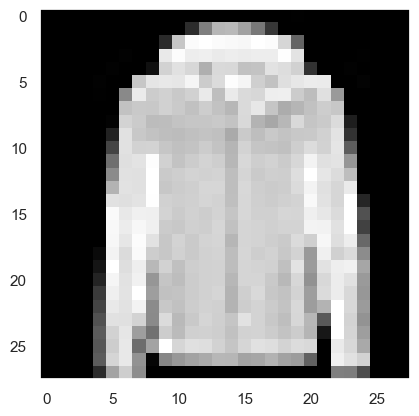

In [ ]:
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "T-shirt/top" , "Trouser" , "Pullover" , "Dress" , "Coat" , "Sandal" ,
               "Shirt" , "Sneaker" , "Bag" , "Ankle boot" ])

# Inspect some aspects of the data (in general, you should play around with the data
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

#**Part 2.1 [Student, 5 mins] : Examining class balance**

In any dataset, but especially in classification datasets, it is important to work out whether the dataset is balanced. As we are using an MNIST dataset, we are almost guaranteed to have a balanced dataset, but there are many applications where this is not the case. Health for example often has a high number of healthy cases (because the disease in question is rare) or pathological cases (because the number of healthy people who get scanned for diseases they don't have is low).

Before just running a 'hist' function, you'll need to know how many classes you have. Here we have been lucky, so I suppose 'hist' will work (defaults to 10 classes).

### Imbalance
Humans are notoriously bad at creating random data. For example, ask a person to generate random coin-flips and they will be unlikely to give you 5 heads in a row, even if they need to make a list of 32 random flips (where having 5 in a row is likely). Similarly, don't focus on the one or two classes which are slightly imbalanced. With 10 classes, one of them is bound to have a different proportion to the others. Just beware cases where one class is highly over-represented... 1.5x or 0.5x the others.

Run the code in the cell below and inspect the distributions. What do you see? Do they look balanced or imbalanced?

Note: Checking for class balance is essential to understand if the dataset is biased and to decide on handling imbalanced data if necessary.

In [ ]:
# Let's look at the distribution of labels in the training, validation and test sets

unique_total = np.unique(y_train).shape[0]

print("Total Unique Classes: ", unique_total)

plt.hist(y_train)
plt.show()
plt.hist(y_valid)
plt.show()
plt.hist(y_test)
plt.show()

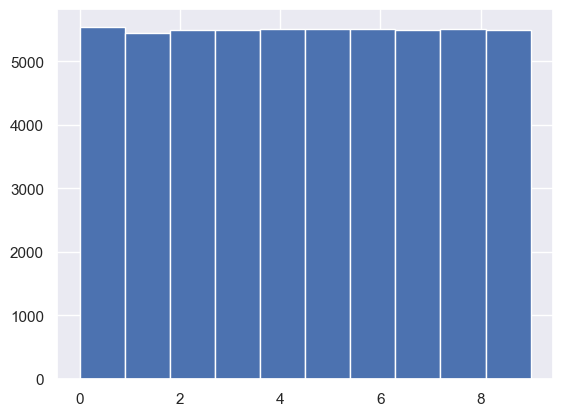


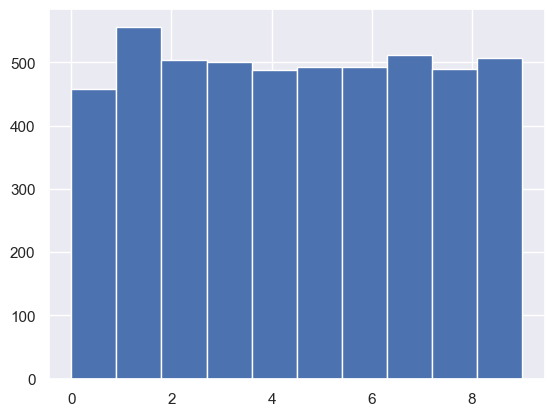


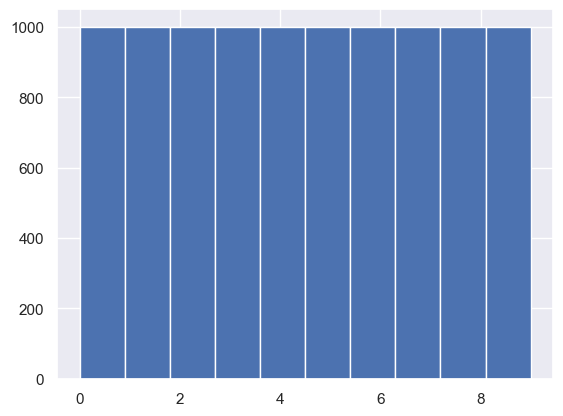

#**Part 2.2 [TA, 5 mins]: Discuss class balance**

Go through the discussion and part 1 slides in provided powerpoint and explain the balance of the classes in their training, validation and testing sets.

Highlight why class balance is important:

* Avoiding Bias: Balanced classes ensure the neural network learns to recognise
all classes equally well, preventing bias towards majority classes.

* Training Stability: Balanced datasets lead to more stable and reliable training processes, avoiding misleading performance metrics.

* Accurate Evaluation: Balanced classes help ensure evaluation metrics like accuracy, precision, recall, and F1-score are more reflective of true model performance across all classes.

#**Part 3.1 [As a class, 15 mins]: Implementing a Simple Neural Network Code with Keras**

For this section, go through the part 3 slides as the students run this code cell and explain the layout of our neural network, as well as some potential limitations.

*Student instructions/additional text below:*

We will use the keras version built into tensorflow version 2. It is remarkably simple for building, training and evaluating networks. This is of course if you want to build fairly... 'mainstream' networks. If you are being super-creative, it may require you to create your own layer-types but that is far too advanced for this course. In this case, we're just going to create a few simple layers.

### A word on neural networks and input data

Straight off the bat, some of you may be wondering... what on earth are we doing? A fully-connected neural network for image data. As you can see, the first layer is a 'flattening' layer which will essentially turn our 28x28 images into a 576x1 line. Fortunately, the remaining layers are all fully connected, so we won't lose any of our important spatial interactions.

What do I mean here? Well, by making the object a line, we could be losing some of the spatial interactions (i.e., vertical or horizontal pixels). Instead, by ,using fully-connected (here called 'Dense') we connect every pixel to every other pixel (not exactly, because the size is 300, 100 and 10). The main disadvantage of this approach is that we are tacitly looking for relationships between the top left and bottom right pixel (which is a bit daft), making this model needlessly redundant. Still, it is a first step.

Note: Implementing this simple neural network serves to illustrate how neural networks are built and trained. The focus here is on understanding the architecture rather than optimizing the model.

In [ ]:
# This is *all* the code needed to define the network architecture
#  1 input layer + 2 hidden layers of sizes 300 and 100 + 1 output layer
model = keras.models.Sequential()   # This is a style of building networks - the easiest option
model.add(keras.layers.Flatten(input_shape = [28 , 28]))   # our inputs are 28 x 28 arrays, so need to become 1D
model.add(keras.layers.Dense(300, activation = "relu"))    # first hidden layer
model.add(keras.layers.Dense(100, activation = "relu"))    # second hidden layer
model.add(keras.layers.Dense(10, activation = "softmax"))  # output layer

#**Part 4.1 [Student, 15 mins]: Performance and Predictions**

Run through the below cells yourself. As you do, can you try and interpret the following?
- Before running the `model.summary` command, can you calculate how many parameters you think the NN should have?
- What do you think of the model's learning curves (loss/accuracy curves)?
- Take a look at how the model makes predictions, paying attention to the actual numeric probabilities. How do you interpret these values? Is your model making good predictions?

Note: Evaluating model performance and understanding predictions are critical steps in the ML workflow to ensure the model generalises well to new data.

In [ ]:
# Print out some info on the network - take note of the number of parameters (weights and biases)
# Can you calculate the number of parameters yourself?
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Couple the architecture definition to a loss function and optimiser (and other performance metrics)
# Note that we use sparse_categorical_crossentropy because the entries in y_train are just numbers from 0 to 9
# If y_train was encoded as one-hot vectors, then the appropriate loss would be categorical_crossentropy instead
# We will use the SGD optimiser here, but Adam is another popular choice
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
# Now train (fit) the model, specifying appropriate data and number of epochs (small here to save time)
# Save the history of metrics versus epochs - *always* keep this
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7080 - accuracy: 0.7676 - val_loss: 0.4917 - val_accuracy: 0.8372
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4841 - accuracy: 0.8308 - val_loss: 0.4397 - val_accuracy: 0.8506
Epoch 3/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4399 - accuracy: 0.8459 - val_loss: 0.4225 - val_accuracy: 0.8520
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4133 - accuracy: 0.8539 - val_loss: 0.3949 - val_accuracy: 0.8600
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3951 - accuracy: 0.8613 - val_loss: 0.3883 - val_accuracy: 0.8648


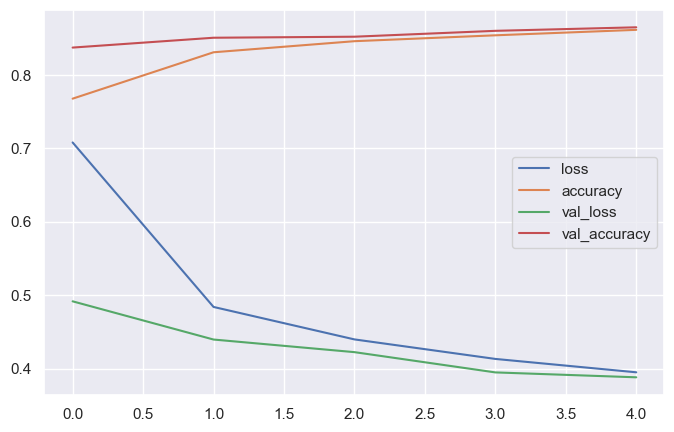

In [ ]:
# Simple way to plot the history information (see later for more detail)
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.show()

In [ ]:
# Now run the model on the test set and get results (loss and accuracy both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.4260880947113037, 0.8468000292778015]


### Predictions

It is always important, to have a look at individual examples when doing image classification to convince ourselves that our network has learned something. Here we will use our model to predict our first three test samples and then see how well it performs.

1/1 [==============================] - 0s 156ms/step
Prediction:  Ankle boot
Ground Truth: Ankle boot
Prediction:  Pullover
Ground Truth: Pullover
Prediction:  Trouser
Ground Truth: Trouser


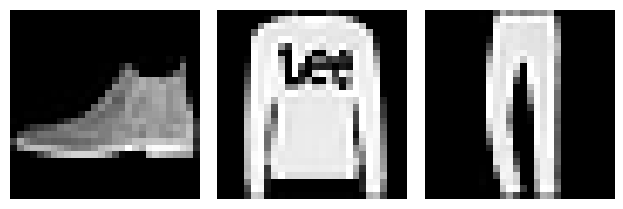

In [ ]:
# We can inspect the output class predictions
y_pred = model.predict(X_test[:3])  # use the first three test cases as an example
# print(y_pred)   # predicted classes

fig, axes = plt.subplots(1, 3)

for i_index in range(0, 3):
    print("Prediction: ", class_names[np.argmax(y_pred[i_index])])
    print("Ground Truth:", class_names[y_test[i_index]])

    axes[i_index].imshow(X_test[i_index].reshape((28,28)), cmap="gray")
    axes[i_index].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

1/1 [==============================] - 0s 17ms/step
[[0.   0.   0.   0.   0.   0.07 0.   0.15 0.01 0.76]
 [0.   0.   0.97 0.   0.01 0.   0.02 0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


#**Part 4.2 [TA, 15 mins]: Discuss Performance and Predictions**

After students have had time to go through the code and think about the interpretation of the outputs themselves, discuss the part 4 slides with the class.

#**Part 5 [Student, 30 mins]: Further exploration**

The studenrs can now do some further independent exploration. For example, let's see why make these particular choices for architecture and parameters.

We will set up some more general code so that we can build and compare a range of networks.

Note: This section is for demonstration purposes, but encourages experimentation with different network architectures and hyperparameters to see their effects on model performance.

In [ ]:
# Plug in some parameter values of your chosing below, and see how things change

# Let's allow the size of the training and validation sets to change
#n_train = n_total   # as above
#n_valid = 5000      # as above
n_train = ???   # Try and use a different number/size
n_valid = ???   # Try and use a different number/size

# Define the number and size of hidden layers
#hiddensizes = [300, 100]  # this was what we did above
hiddensizes = [???]   # instead, try a simpler version with only one layer

# Define the activation function to be used by hidden layers
actfn = "relu"

# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01

# Set size of batch and number of epochs
batch_size = 50
n_epochs = 20

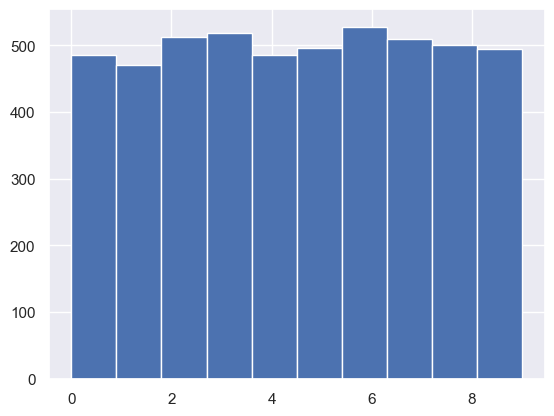

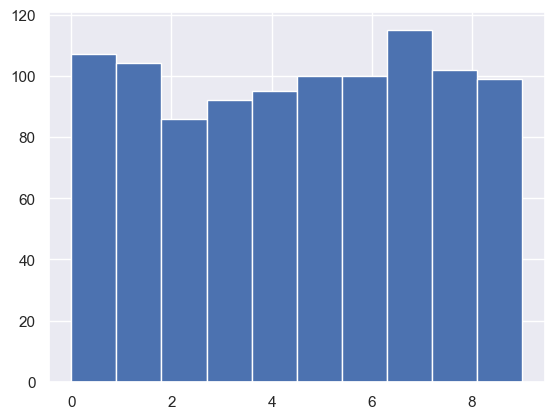

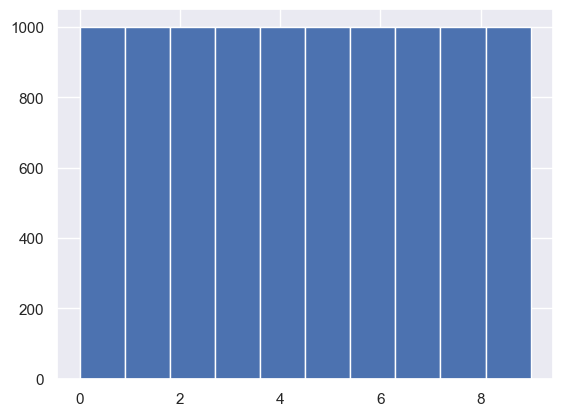

In [ ]:
# Let's look at the distribution of labels in the training, validation and test sets we will use. Try and put your code here (hint above)
plt.hist(y_train[:n_train])
plt.show()
plt.hist(y_valid[:n_valid])
plt.show()
plt.hist(y_test)
plt.show()

In [ ]:
# Build a more general model using various settings
def model_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28 , 28]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model

In [ ]:
# Create our model
model = model_factory(hiddensizes, actfn, optimizer, learningrate)
# Show summary info
model.summary()
# Train it with only n_train training samples and n_valid validation samples, and other settings specified above
# history = model.fit( ### you should fill this in yourself ### )
history = model.fit(X_train[0:n_train], y_train[0:n_train], epochs=n_epochs, validation_data=(X_valid[0:n_valid], y_valid[0:n_valid]))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


c:\Users\emper\anaconda3\envs\mbd\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


157/157 [==============================] - 1s 2ms/step - loss: 1.5765 - accuracy: 0.5274 - val_loss: 1.1365 - val_accuracy: 0.6550
Epoch 2/20
157/157 [==============================] - 0s 1ms/step - loss: 1.0034 - accuracy: 0.6690 - val_loss: 0.8807 - val_accuracy: 0.7130
Epoch 3/20
157/157 [==============================] - 0s 1ms/step - loss: 0.8422 - accuracy: 0.7176 - val_loss: 0.7861 - val_accuracy: 0.7370
Epoch 4/20
157/157 [==============================] - 0s 1ms/step - loss: 0.7613 - accuracy: 0.7444 - val_loss: 0.7226 - val_accuracy: 0.7600
Epoch 5/20
157/157 [==============================] - 0s 1ms/step - loss: 0.7054 - accuracy: 0.7630 - val_loss: 0.6836 - val_accuracy: 0.7650
Epoch 6/20
157/157 [==============================] - 0s 1ms/step - loss: 0.6638 - accuracy: 0.7792 - val_loss: 0.6550 - val_accuracy: 0.7970
Epoch 7/20
157/157 [==============================] - 0s 1ms/step - loss: 0.6333 - accuracy: 0.7876 - val_loss: 0.6188 - val_accuracy: 0.7970
Epoch 8/20
157/15

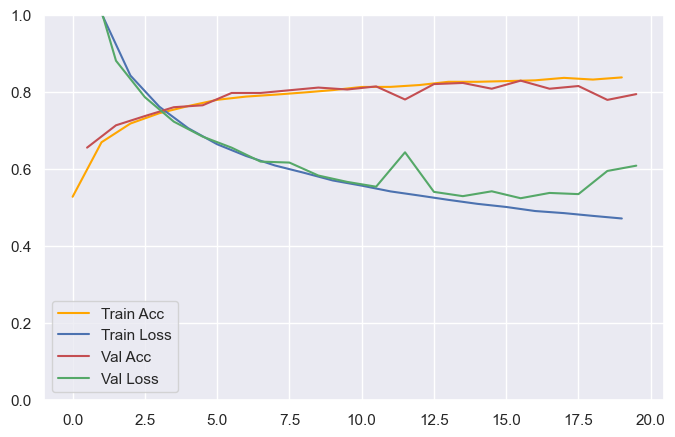

In [ ]:
# Plot the results (shifting validation curves appropriately)
plt.figure(figsize=(8,5))
plt.plot(np.arange(0,n_epochs),history.history['accuracy'], color='orange')
plt.plot(np.arange(0,n_epochs),history.history['loss'],'b')
plt.plot(np.arange(0,n_epochs)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
plt.plot(np.arange(0,n_epochs)+0.5,history.history['val_loss'],'g')
plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
# Display best accuracy on validation set
max_val_acc = np.max(history.history['val_accuracy'])
print(f'Best validation accuracy = {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places
# Evaluate on testset
testres = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test set = {testres[1]:.3f}')

Best validation accuracy = 0.829
Accuracy on test set = 0.770


In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size):
    # Create our model
    model = model_factory(hiddensizes, actfn, optimizer, learningrate)
    # Train it
    history = model.fit(X_train[0:n_train], y_train[0:n_train], epochs=n_epochs, validation_data=(X_valid[0:n_valid], y_valid[0:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test[0:n_train], y_test[0:n_train], verbose=0)
    return (max_val_acc, testres[1], history)

##**Extension: Exploring Performance with Network Size and Training Set Size**

As an extension, explore how the performance of a neural network varies with different network sizes and training set sizes. You can use the `random_model` function to make random selections for these parameters and then observe the resulting performance.

Try to write some code to do this or use ChatGPT.

Note: This extension is designed to show how varying network sizes and training set sizes affect performance, encouraging deeper exploration, for demonstration purposes.

In [ ]:
def random_model():
    # Make some random selections to see how performance varies with network size and training set size
    lsize=[10,100,1000]   # just have three options for layer sizes
    # start with three candidate layers
    hiddensizes = [lsize[np.random.randint(0,3)], lsize[np.random.randint(0,3)], lsize[np.random.randint(0,3)]]
    # then keep between 1 and 3 layers
    hiddensizes = hiddensizes[:np.random.randint(1,4)]
    n_train = np.random.randint(1,10)*10**np.random.randint(2,4)  # numbers between 100 and 9000 (logarithmically selected)
    n_epochs = 10  # to speed things up a bit (not recommended for full evaluation)
    # Now build, run and report
    valacc, testacc, history = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    print(f'Settings are: {(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)}')
    print(f'Validation accuracy = {valacc:.3f} and Test accuracy = {testacc:.3f}')
    retval = [hiddensizes, n_train, valacc, testacc]
    return retval

In [ ]:
res = random_model()

In [ ]:
print(res)